# New dataset prepration

## in this notebook, we make new dataset

In [1]:
%load_ext autoreload

In [6]:
%autoreload
import random
import numpy as np
import sys
import os
import glob
import imageio
import time
import shutil
import matplotlib.pyplot as plt
sys.path.append("..")
from scipy import ndimage, signal
from cv2 import medianBlur

from PIL import Image
from costum_arild.source.utils import image_processing_utils, model_utils

In [3]:
def mask_unknown_class(arr, unknown_class):
    """
    This function returns a numpy array which masks elements with has value of unknown class.
    """
    if arr.ndim == 3:
        if arr.shape[-1] != unknown_class.shape[0]:
            raise ValueError(f'unknown class should be an array of [R,G,B] now it is {unknown_class.shape}')
        return (arr == unknown_class).all(axis=-1)
    elif arr.ndim == 2:
        return arr == unknown_class

def most_selected_class(image_matrix, select_class, threshold):
    """
    True if select_class is more than threshold
    """
    # Check that the amount of the unknown class
    class_mask = image_matrix == select_class

    if np.sum(class_mask) > threshold * class_mask.size:
        return True
    else:
        return False


def make_small_image_index(image_matrix, label_matrix=None, image_size=512, do_overlap=False):
    """
    indecies to devide images into small images with image size of (image_size x image_size)
    """
    if do_overlap:
        shape_0_indices = list(
            range(image_size // 4, image_matrix.shape[0], image_size // 4))[:-4]
        shape_1_indices = list(
            range(image_size // 4, image_matrix.shape[1], image_size // 4))[:-4]
    else:
        shape_0_indices = list(range(0, image_matrix.shape[0], image_size))
        shape_0_indices[-1] = image_matrix.shape[0] - image_size
        shape_1_indices = list(range(0, image_matrix.shape[1], image_size))
        shape_1_indices[-1] = image_matrix.shape[1] - image_size

    return shape_0_indices, shape_1_indices


def devide_small_image(large_img_arr, large_lbl_arr_2d, image_size, dst_path, unknown_class):
    """
    devide images and array into image_size and save them into dst_path
    """
    if large_img_arr.shape != large_lbl_arr.shape:
        raise ValueError(f'shape of image and labels should be the same {large_img_arr.shape} != {large_lbl_arr.shape}')
        
    # get indecies of small images
    list_0_idx, list_1_idx = make_small_image_index(large_lbl_arr_2d, 
                                            image_size=image_size, do_overlap=False)
    
    # make the directories if needed
    small_image_list = []
    small_label_list = []
    
    for i_idx in list_0_idx:
        for j_idx in list_1_idx:
            small_label = large_lbl_arr_2d[ i_idx : i_idx+image_size,
                                            j_idx : j_idx+image_size ]

            small_image = large_img_arr[ i_idx : i_idx+image_size,
                                            j_idx : j_idx+image_size ]
            
            # if more than 50% of class is unknown it will not be included
            if most_selected_class(image_matrix=small_image, 
                                   select_class=unknown_class, threshold=0.5):
                print('more than half is unknown so ignored')
                continue
                
            # image name
            tmp_img_name = f"{pare_img_names[idx].replace('.png', '')}_{i_idx}_{j_idx}.png"
            
            save_to_png(img_array=small_label, 
                        img_path=os.path.join(dst_path_lbl, tmp_img_name))
            
            save_to_png(img_array=small_image, 
                        img_path=os.path.join(dst_path_img, tmp_img_name))
    return True

def save_to_png(img_array, img_path):
    # save to file
    img_png = Image.fromarray(img_array.astype(np.uint8))
    img_png.save(img_path)
    

## 512x512 images

read image

In [4]:
all_label_path = '/home/saeid/phd/segmentation/dataset/large images/rasters_png/all_label_correct_ipad'
all_label_median_path = '/home/saeid/phd/segmentation/dataset/large images/rasters_png/all_label_correct_ipad/near_color_median'
pare_label_path = '/home/saeid/phd/segmentation/dataset/new_dataset/label'
pare_img_path = '/home/saeid/phd/segmentation/dataset/new_dataset/image'

# get all the image paths
all_label_image_path = glob.glob(os.path.join(all_label_path, '*.png'))
all_label_median_image_path = glob.glob(os.path.join(all_label_median_path, '*.png'))
pare_label_image_path = glob.glob(os.path.join(pare_label_path, '*.png'))
pare_img_image_path = glob.glob(os.path.join(pare_img_path, '*.png'))

# get all the image names
all_label_names = [os.path.split(name)[-1] for name in glob.glob(os.path.join(all_label_path, '*.png'))]
all_label_median_name = [os.path.split(name)[-1] for name in glob.glob(os.path.join(all_label_median_path, '*.png'))]
pare_label_names = [os.path.split(name)[-1] for name in glob.glob(os.path.join(pare_label_path, '*.png'))]
pare_img_names = [os.path.split(name)[-1] for name in glob.glob(os.path.join(pare_img_path, '*.png'))]

## Ex1

in this experiment we just devide images into 512x512 images

In [5]:
dst_path = '/home/saeid/phd/segmentation/dataset/new_dataset/Ex1_image_unknown0/'

In [24]:
image_size = 512
# determines if we need to show messages or not
verbose = True
UNKNOWN_CLASS = 0
small_image_list = []
small_label_list = []

dst_path_img = os.path.join(dst_path, 'image')
dst_path_lbl = os.path.join(dst_path, 'label')

os.makedirs(dst_path_img, exist_ok=True)
os.makedirs(dst_path_lbl, exist_ok=True)

for idx, img_path in enumerate(pare_img_image_path):    
    print(f"working on image {pare_img_names[idx].replace('.png', '')}")
    start = time.time()
    large_img_arr = image_processing_utils.read_png_file(image_path=pare_img_image_path[idx])
    large_lbl_arr = image_processing_utils.read_png_file(image_path=pare_label_image_path[idx])
    # change rgb to 2d_class labels
    
    large_lbl_arr_2d = image_processing_utils.replace_rgb_to_class(large_lbl_arr, 
                                                                   unknown_zero_flag=True)
    current_time = time.time()
    if verbose:
        print(f'loading images took: {current_time - start}')
    
    # now we dont need to rotate the image
    # rotate image by angle
    # rotated_lbl_arr_2d = image_processing_utils.rotate_image_skimage(angle=30, 
    #                                                                      img=large_lbl_arr_2d)
    
#     # we might need to swap the value of unknown class
#     UNKNOWN_CLASS = 0
#     large_lbl_arr_2d = image_processing_utils.swap_value_np(array=large_lbl_arr_2d, val1=5, val2=0)
#     current_time = time.time()
#     if verbose:
#         print(f'swapping classes took: {current_time - start}')
    
    devide_small_image(large_img_arr=large_img_arr, large_lbl_arr_2d = large_lbl_arr_2d, 
                       image_size=image_size, dst_path=dst_path, unknown_class=UNKNOWN_CLASS)
    current_time = time.time()
    if verbose:
        print(f'deviding took: {current_time - start}')


### Split images to train validate and test

In [7]:
train_rate=0.8
val_rate=0.2
# test_rate=0.1
src_path = '/home/saeid/phd/segmentation/dataset/new_dataset/Ex3_images/small_images_1024/small_image'
dst_path = '/home/saeid/phd/segmentation/dataset/new_dataset/Ex3_images/small_images_1024/small_image'
model_utils.dataset_split_train_vlidation_test(src_path=src_path, dst_path=dst_path, 
                                    train_rate=train_rate,
                                    val_rate=val_rate)

## Draft

In [6]:
# input image and output small division of it
# check if image and label has the same name
idx = 0
large_img_arr = image_processing_utils.read_png_file(image_path=pare_img_image_path[idx])
large_lbl_arr = image_processing_utils.read_png_file(image_path=pare_label_image_path[idx])
# change rgb to 2d_class labels
UNKNOWN_CLASS = 0
large_lbl_arr_2d = image_processing_utils.replace_rgb_to_class(large_lbl_arr, 
                                                               unknown_zero_flag=True)

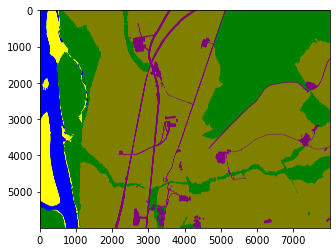

In [14]:
plt.imshow(image_processing_utils.label_to_rgb(large_lbl_arr_2d, unknown_zero_flag=True))

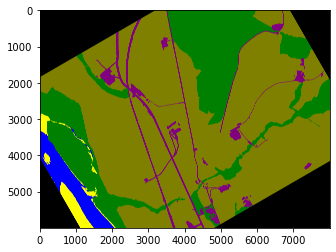

In [19]:
# scipy
# rotated_img_arr = image_processing_utils.rotate_image_scipy(angle=30, img=large_img_arr)
# rotated_lbl_arr = image_processing_utils.rotate_image_scipy(angle=30, img=large_lbl_arr)
# skimage
rotated_img_arr = image_processing_utils.rotate_image_skimage(angle=30, img=large_img_arr)
rotated_lbl_arr_2d = image_processing_utils.rotate_image_skimage(angle=30, img=large_lbl_arr_2d)
plt.imshow(image_processing_utils.label_to_rgb(rotated_lbl_arr_2d, unknown_zero_flag=True))

In [18]:
np.unique(rotated_lbl_arr_2d)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [21]:
# tmp_unknown_class=np.array([0,0,0])
# unknown_mask_3d = mask_unknown_class(rotated_lbl_arr, unknown_class=tmp_unknown_class)
# unknown_mask = mask_unknown_class(rotated_lbl_arr_2d, unknown_class=UNKNOWN_CLASS)

In [64]:
tmp_0_idx, tmp_1_idx = make_small_images(rotated_lbl_arr_2d, image_size=512, do_overlap=False)

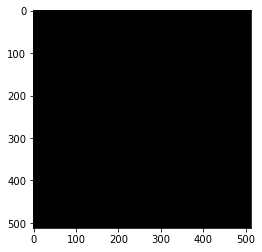

In [72]:
img_idx = 1
small_label = rotated_lbl_arr_2d[tmp_0_idx[img_idx]:tmp_0_idx[img_idx]+512,
                                 tmp_1_idx[img_idx]:tmp_1_idx[img_idx]+512]

small_image = rotated_img_arr[tmp_0_idx[img_idx]:tmp_0_idx[img_idx]+512,
                                 tmp_1_idx[img_idx]:tmp_1_idx[img_idx]+512]
plt.imshow(small_image)

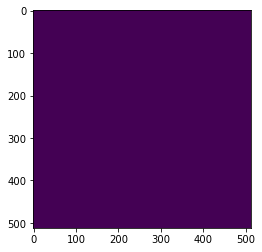

In [73]:
plt.imshow(small_label)

In [74]:
most_selected_class(image_matrix=small_label, select_class=0, threshold=0.9)

True

# Calculating class information

In [1]:
import numpy as np
import sys
import os
import glob
import imageio
import time
sys.path.append("..")
from scipy import ndimage, signal
from cv2 import medianBlur
import pandas as pd

from PIL import Image
from costum_arild.source.utils import image_processing_utils

In [2]:
def class_count_list_dataframe(class_count_list, unknown_zero):
    class_df = pd.DataFrame(class_count_list, dtype='float32')

    class_df.loc['class_sum'] = class_df.sum(axis=0)

    if unknown_zero == True:
        class_df = class_df.rename(columns={5: "water", 1: "gravel", 2: "vegetation", 3: "farmland", 4: "human construction", 0: "unknown"})
    else:
        class_df = class_df.rename(columns={0: "water", 1: "gravel", 2: "vegetation", 3: "farmland", 4: "human construction", 5: "unknown"})

    class_df.loc['class_sum_percent'] = ((class_df.loc['class_sum'] / class_df.loc['class_sum'].sum()) * 100)
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    return class_df

### All images

In [25]:
all_lbl_path = '/home/saeid/phd/segmentation/dataset/new_dataset/Ex1_image_unknown0/complete_dataset/label'
all_lbl_class_count = image_processing_utils.count_class_list_directory_2d(all_lbl_path)

In [39]:
unknown_zero = True
all_class_df = class_count_list_dataframe(class_count_list=all_lbl_class_count, unknown_zero=unknown_zero)
all_class_df#.loc['class_sum_percent'].to_frame()

,unknown,gravel,vegetation,farmland,human construction,water
0,0.00,57146.00,64831.00,0.00,8259.00,131908.00
1,91290.00,0.00,0.00,165405.00,5449.00,0.00
2,72293.00,0.00,189851.00,0.00,0.00,0.00
3,0.00,0.00,262144.00,0.00,0.00,0.00
4,0.00,0.00,262144.00,0.00,0.00,0.00
...,...,...,...,...,...,...
13358,0.00,37911.00,107079.00,0.00,0.00,117154.00
13359,0.00,454.00,126879.00,134811.00,0.00,0.00
13360,0.00,0.00,262144.00,0.00,0.00,0.00
class_sum,20838972.00,73477888.00,2178562560.00,922013056.00,144504192.00,163109392.00


In [27]:
# all images that are just forst
all_vegetation_only = (all_class_df['unknown'] == 0) & (all_class_df['gravel'] == 0) & (all_class_df['farmland'] == 0) & (all_class_df['human construction'] == 0) & (all_class_df['water'] == 0)
print(f'all the images: (just vegetation images: {all_vegetation_only.sum()}) | (rest of images:{all_vegetation_only.shape[0]-2-all_vegetation_only.sum()})')

all the images: (just vegetation images: 4919) | (rest of images:8442)


### Train images

In [36]:
train_lbl_path = '/home/saeid/phd/segmentation/dataset/new_dataset/Ex1_image_unknown0/train/label/img'
train_lbl_class_count = image_processing_utils.count_class_list_directory_2d(train_lbl_path)
train_class_df = class_count_list_dataframe(class_count_list=train_lbl_class_count, unknown_zero=unknown_zero)
train_class_df.loc['class_sum_percent'].to_frame()

,class_sum_percent
unknown,0.60
gravel,2.13
vegetation,62.53
farmland,26.12
human construction,4.09
water,4.52


In [24]:
# train images that are just forst
train_vegetation_only = (train_class_df['unknown'] == 0) & (train_class_df['gravel'] == 0) & (train_class_df['farmland'] == 0) & (train_class_df['human construction'] == 0) & (train_class_df['water'] == 0)
print(f'Train the images: (just vegetation images: {train_vegetation_only.sum()}) | (rest of images:{train_vegetation_only.shape[0]-2-train_vegetation_only.sum()})')

Train the images: (just vegetation images: 3482) | (rest of images:5871)


### Val images

In [38]:
val_lbl_path = '/home/saeid/phd/segmentation/dataset/new_dataset/Ex1_image_unknown0/val/label/img'
val_lbl_class_count = image_processing_utils.count_class_list_directory_2d(val_lbl_path)
val_class_df = class_count_list_dataframe(class_count_list=val_lbl_class_count, unknown_zero=unknown_zero)
val_class_df

,unknown,gravel,vegetation,farmland,human construction,water
0,0.00,0.00,181377.00,66490.00,14277.00,0.00
1,0.00,0.00,0.00,259740.00,2404.00,0.00
2,0.00,0.00,115152.00,19742.00,127250.00,0.00
3,0.00,0.00,259177.00,2967.00,0.00,0.00
4,0.00,0.00,262144.00,0.00,0.00,0.00
...,...,...,...,...,...,...
2669,0.00,0.00,61981.00,200163.00,0.00,0.00
2670,0.00,0.00,262144.00,0.00,0.00,0.00
2671,0.00,0.00,262144.00,0.00,0.00,0.00
class_sum,4433145.00,14231834.00,425890752.00,191943200.00,29635136.00,34314692.00


In [23]:
# all images that are just forst
val_vegetation_only = (val_class_df['unknown'] == 0) & (val_class_df['gravel'] == 0) & (val_class_df['farmland'] == 0) & (val_class_df['human construction'] == 0) & (val_class_df['water'] == 0)
print(f'val the images: (just vegetation images: {val_vegetation_only.sum()}) | (rest of images:{val_vegetation_only.shape[0]-2-val_vegetation_only.sum()})')

val the images: (just vegetation images: 952) | (rest of images:1720)
